In [1]:
import numpy as np
import matplotlib.pyplot as plt
from coffea.util import load, save
from coffea.processor import accumulate
from coffea.lookup_tools.dense_lookup import dense_lookup

In [2]:
# Load processed histograms from btag_eff workflow
year = "2017"
wp = "medium"
btag_eff_histograms = load(f"../outputs/btag_eff/{year}/{year}_processed_histograms.coffea")
btag_eff_histograms

{'DYJetsToLL': {'eff': Hist(
    Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500, 1000], name='jet_pt', label='$p_T(\\text{jet})$ [GeV]'),
    Regular(25, 0, 2.4, name='jet_abseta', label='$|\\eta(\\text{jet})|$'),
    IntCategory([0, 4, 5], name='jet_flavor', label='hadronFlavour${jet}$'),
    Regular(2, 0, 2, name='jet_pass_wp', label='pass WP'),
    storage=Double()) # Sum: 141199.24493946828},
 'SingleTop': {'eff': Hist(
    Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500, 1000], name='jet_pt', label='$p_T(\\text{jet})$ [GeV]'),
    Regular(25, 0, 2.4, name='jet_abseta', label='$|\\eta(\\text{jet})|$'),
    IntCategory([0, 4, 5], name='jet_flavor', label='hadronFlavour${jet}$'),
    Regular(2, 0, 2, name='jet_pass_wp', label='pass WP'),
    storage=Double()) # Sum: 4120593.488584106},
 'tt': {'eff': Hist(
    Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500, 1000], name='jet_pt', label='$p_T(\\text{jet})$ [GeV]'),
    Regular(25, 0, 2.4, name='jet_abseta', la

In [3]:
# Accumulate all the samples and 
btag_efficiency_hist = []
for sample in btag_eff_histograms:
    btag_efficiency_hist.append(btag_eff_histograms[sample]["eff"])
btag_efficiency_hist = accumulate(btag_efficiency_hist)
btag_efficiency_hist

Hist(
  Variable([20, 60, 90, 120, 150, 180, 210, 240, 300, 500, 1000], name='jet_pt', label='$p_T(\\text{jet})$ [GeV]'),
  Regular(25, 0, 2.4, name='jet_abseta', label='$|\\eta(\\text{jet})|$'),
  IntCategory([0, 4, 5], name='jet_flavor', label='hadronFlavour${jet}$'),
  Regular(2, 0, 2, name='jet_pass_wp', label='pass WP'),
  storage=Double()) # Sum: 1197801205.018606

In [4]:
# Compute the b-tagging efficiency
efficiency = btag_efficiency_hist[{"jet_pass_wp": True}] / btag_efficiency_hist[{"jet_pass_wp": sum}]

In [5]:
# Create a efficiency lookup table
efflookup = dense_lookup(efficiency.values(), [ax.edges for ax in efficiency.axes]) 
efflookup

3 dimensional histogram with axes:
	1: [  20.   60.   90.  120.  150.  180.  210.  240.  300.  500. 1000.]
	2: [0.    0.096 0.192 0.288 0.384 0.48  0.576 0.672 0.768 0.864 0.96  1.056
 1.152 1.248 1.344 1.44  1.536 1.632 1.728 1.824 1.92  2.016 2.112 2.208
 2.304 2.4  ]
	3: [0. 1. 2. 3.]

In [6]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(43, 0.1, np.array([0, 1, 2]))

array([0.01856892, 0.17408551, 0.77472286])

In [7]:
# Notice that hadron flavours (0, 4, 5) turn into (0, 1, 2). Let's modify them to their original values
efflookup._axes[-1] = np.array([0., 4., 5., 6.]) 

In [8]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(43, 0.1, np.array([0, 4, 5]))

array([0.01856892, 0.17408551, 0.77472286])

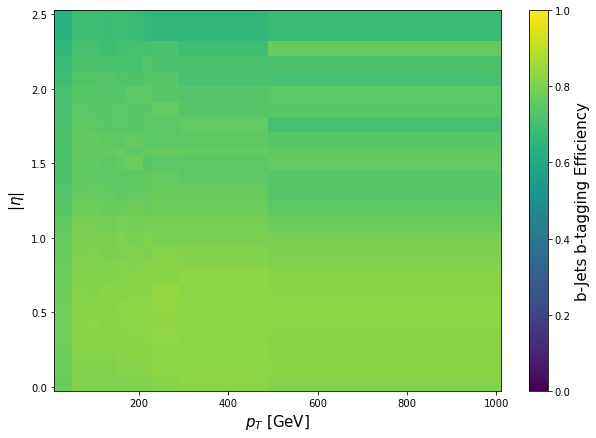

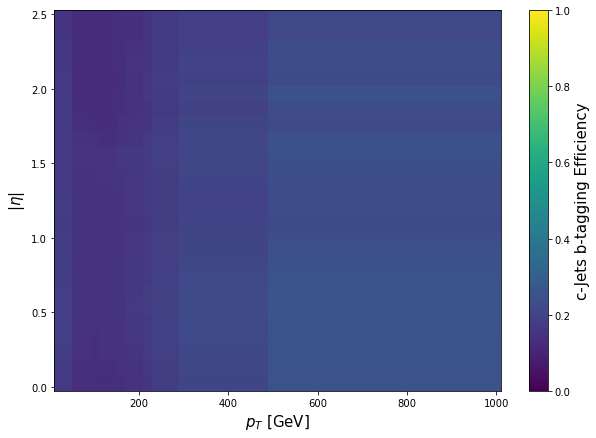

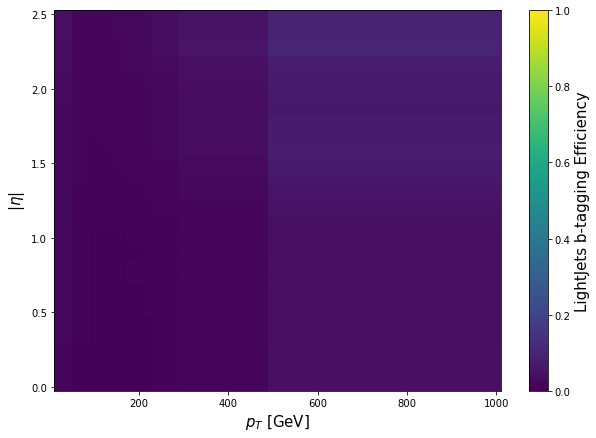

In [9]:
# Let's visualize the efficiencies
pts = np.linspace(20, 1000)
etas = np.linspace(0, 2.5)
pt, eta = np.meshgrid(pts, etas)

flavor_tags = {0: "LightJets", 4: "c-Jets", 5: "b-Jets"}
for i, flavor in enumerate([5, 4, 0]):
    fig, ax = plt.subplots(figsize=(10, 7))
    heatmap = ax.pcolormesh(pt, eta, efflookup(pt, eta, flavor), cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(heatmap)
    ax.set_xlabel('$p_T$ [GeV]', fontsize=15)
    ax.set_ylabel('$|\eta|$', fontsize=15)
    cbar.set_label(f'{flavor_tags[flavor]} b-tagging Efficiency', fontsize=15)

In [10]:
# Save efficiency lookup table for later use in the computation of the b-tagging weights
output_path = f"../analysis/data/btag_eff_deepJet_{wp}_{year}.coffea"
save(efflookup, output_path)